In [1]:
# Pour lire les données
from bs4 import BeautifulSoup
import pandas as pd

# analys sentiments
from textblob import TextBlob
import statistics

# Pour le prétraitement des données
# Token et filtre et lemma
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Pour analyse de sentiments
from textblob import TextBlob
from textblob_fr import PatternTagger, PatternAnalyzer


# Chargement des données

In [2]:
with open('../data/grexit.txt', 'r', encoding='utf-8') as file:
        grexit = file.read()
        
with open('../data/brexit.txt', 'r', encoding='utf-8') as file:
        brexit = file.read()

In [3]:
soup = BeautifulSoup(grexit, 'html.parser') 
texts = soup.find_all('text')

grexit = pd.DataFrame(columns=['id', 'title', 'author', 'year', 'date', 'section', 'sourcename', 'text'])

for text in texts:
    text_data = {
        'id': text.get('id'),
        'title': text.get('title'),
        'author': text.get('author'),
        'year': text.get('year'),
        'date': text.get('date'),
        'section': text.get('section'),
        'sourcename': text.get('sourcename'),
        'text': text.get_text(separator=" ", strip=True)
    }
    grexit = pd.concat([grexit, pd.DataFrame([text_data])], ignore_index=True)

In [4]:
grexit['pays'] = 'grexit'


In [5]:
soup = BeautifulSoup(brexit, 'html.parser') 
texts = soup.find_all('text')

brexit = pd.DataFrame(columns=['id', 'title', 'author', 'year', 'date', 'section', 'sourcename', 'text'])

for text in texts:
    text_data = {
        'id': text.get('id'),
        'title': text.get('title'),
        'author': text.get('author'),
        'year': text.get('year'),
        'date': text.get('date'),
        'section': text.get('section'),
        'sourcename': text.get('sourcename'),
        'text': text.get_text(separator=" ", strip=True)
    }
    brexit = pd.concat([brexit, pd.DataFrame([text_data])], ignore_index=True)

In [6]:
brexit['pays'] = 'brexit'


In [18]:
data = pd.concat([brexit, grexit])
data = data.reset_index(drop=True)

In [19]:
data.head()

,id,title,author,year,date,section,sourcename,text,pays
0,1,Economie & EntrepriseLe risque grec fait de no...,NULL,2015,07/01/2015,NULL,Le Monde,Economie & EntrepriseLe risque grec fait de no...,brexit
1,2,David Cameron donne des gages aux eurosceptiqu...,Philippe Bernard,2015,07/01/2015,NULL,Le Monde,David Cameron donne des gages aux eurosceptiqu...,brexit
2,3,Merkel calme le jeu avec Athènes et Londres,"Philippe Bernard, Frédéric Lemaître et Jean-Pi...",2015,09/01/2015,NULL,Le Monde,Merkel calme le jeu avec Athènes et Londres Lo...,brexit
3,4,"2015, une année électorale qui va stresser les...",NULL,2015,19/01/2015,NULL,Les Echos,"2015, une année électorale qui va stresser les...",brexit
4,5,La croissance britannique face au doute électoral,"Collomp, Florentin; florentin collomp @fcollom...",2015,28/01/2015,NULL,Le Figaro,La croissance britannique face au doute électo...,brexit


# Traitement des données

In [20]:
nltk.download('punkt')   # Pour la tokenisation
nltk.download('stopwords')  # Pour els mots d'arrêts
nltk.download('wordnet')  # Pour Lemmatisaion

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mbrei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mbrei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mbrei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Suppression : ponctuation, caractères spéciaux, espaces blancs et transformation en minuscule

In [21]:
def pretraitement(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

data['text'] = data['text'].apply(pretraitement)

#### Tokennisation

In [22]:
data['text'] = data['text'].apply(word_tokenize)

##### Mot d'arrêt

In [23]:
def sup_mots_arret(texte):
    mots_arret = set(stopwords.words('french'))
    mots_filtres = [mot for mot in texte if mot not in mots_arret]
    return mots_filtres

data['text'] = data['text'].apply(sup_mots_arret)


#### Lemmatisation

In [24]:
lemmatizer = WordNetLemmatizer()

data['text'] = data['text'].apply(lambda text: [lemmatizer.lemmatize(word) for word in text])

# Model de classif

In [28]:
# POur le modèle 
from sklearn.model_selection import train_test_split  #Séparation du jdd
from sklearn.feature_extraction.text import TfidfVectorizer # Vectoriser X
from sklearn.svm import SVC # Modèle de SVM
from sklearn.metrics import accuracy_score  # calcul accuraccy
from sklearn.preprocessing import LabelEncoder # Encoder Y


In [49]:
X = data['text']
y = data['pays']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
print(label_encoder.classes_,y)

['brexit' 'grexit'] [0 0 0 ... 1 1 1]


In [64]:
# Liste de mots en chaine de caratères :
X_str = [' '.join(phrase) for phrase in X]

# Vectorise
vectorizer = TfidfVectorizer(max_features=10)
X_vectorized = vectorizer.fit_transform(X_str)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.3, random_state=42)

# On utilise un svm
classifier = SVC(kernel='linear')

classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [73]:
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.9634888438133874

## Graphique sentiments

In [16]:
data['text'] = [' '.join(liste) for liste in data['text']]

In [17]:
data.tail()

,id,title,author,year,date,section,sourcename,text,pays
9854,1181,Pierre Moscovici Commissaire européen,GUILLAUME MAUJEAN,2016,12/12/2016,NULL,Les Echos,pierre moscovici commissaire europen 2017 tout...,grexit
9855,1182,"Abandonner l'euro, c'est faire le lit des nati...",NULL,2016,13/12/2016,NULL,Libération,abandonner leuro cest faire lit nationalistes ...,grexit
9856,1183,Royaume-Uni,NULL,2016,16/12/2016,NULL,La Croix,royaumeuni pas postrit rfrendum 23 juin brexit...,grexit
9857,1184,L'Europe face à la montée des populismes,"Malhère, Manon",2016,30/12/2016,NULL,Le Figaro,leurope face monte populismes dboussole rfrend...,grexit
9858,1185,"Depuis quinze ans, l'euro dans les porte-monna...",NULL,2016,31/12/2016,NULL,Midi Libre - CARCA_ML,depuis quinze an leuro portemonnaie europens c...,grexit


### Brexit subjectivite

In [20]:
brexit_data = data.groupby('pays').get_group('brexit')
journal = ['Les Echos', 'Le Monde', 'Le Figaro', 'Libération','La Croix']
subjectivite = []

for i in range(len(journal)):
    brexit_journal = brexit_data.groupby('sourcename').get_group(journal[i])
    brexit_subj = []
    for article in brexit_journal["text"]:
        article_subj = TextBlob(article).sentiment.polarity
        brexit_subj.append(article_subj)
    subj_mean = statistics.mean(brexit_subj)
    subjectivite.append(subj_mean)
    print(i)

0
1
2
3
4


In [40]:
brexit_subjectivite = pd.DataFrame({'Journal':journal, 'Brexit':subjectivite})

### grexit subjectivite

In [28]:
grexit_data = data.groupby('pays').get_group('grexit')
journal = ['Les Echos', 'Le Monde', 'Le Figaro', 'Libération','La Croix']
subjectivite2 = []

for i in range(len(journal)):
    grexit_journal = grexit_data.groupby('sourcename').get_group(journal[i])
    grexit_subj = []
    for article in grexit_journal["text"]:
        article_subj = TextBlob(article, pos_tagger=PatternTagger(), analyzer=PatternAnalyzer()).sentiment
        grexit_subj.append(article_subj[1])
    subj_mean = statistics.mean(grexit_subj)
    subjectivite2.append(subj_mean)
    print(i)

0
1
2
3
4


In [25]:
grexit_subjectivite = pd.DataFrame({'Journal':journal, 'Grexit':subjectivite2})

In [26]:
data_subjectivite = brexit_subjectivite.merge(grexit_subjectivite, on='Journal')

In [27]:
data_subjectivite

,Journal,Grexit_x,Grexit_y
0,Les Echos,0.042392,0.058743
1,Le Monde,0.026650,0.063521
2,Le Figaro,0.047134,0.062718
3,Libération,0.062090,0.062986
4,La Croix,0.041192,0.064282


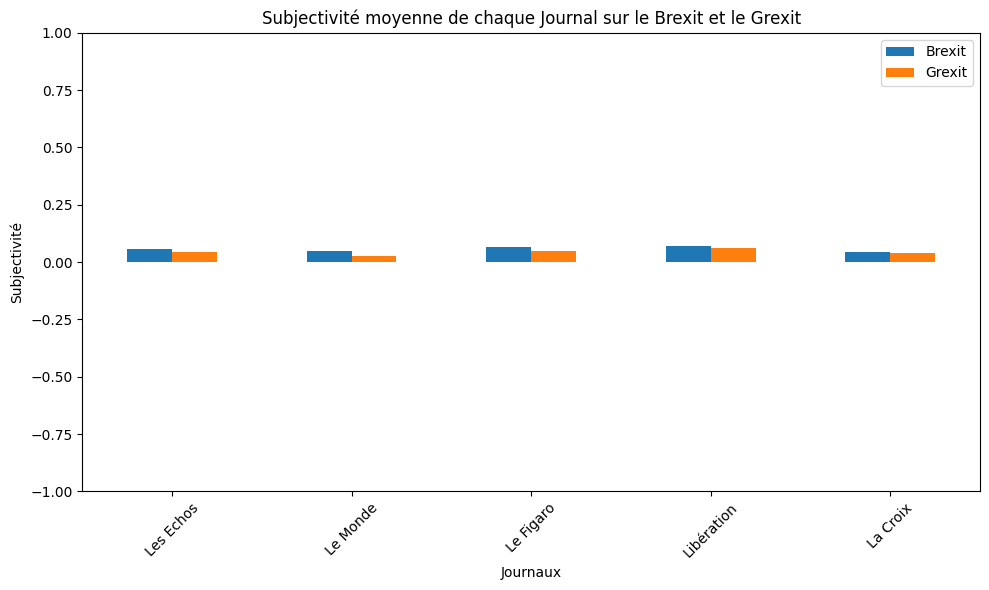

In [47]:
import matplotlib.pyplot as plt

# Créer le graphique
ax = data_subjectivite.plot(kind='bar', x='Journal', figsize=(10, 6))

ax.set_ylim(-1, 1)

# Ajouter des étiquettes, des titres et une légende
ax.set_xlabel('Journaux')
ax.set_ylabel('Subjectivité')
ax.set_title('Subjectivité moyenne de chaque Journal sur le Brexit et le Grexit')
plt.xticks(rotation=45)
plt.tight_layout()

# Afficher le graphique
plt.show()

# Prédiction tweet

In [73]:
import joblib

model = joblib.load('avis_tweet_predict_1000.pkl')

In [74]:
X = [' '.join(liste) for liste in data['text']]
X

['economie entreprisele risque grec fait nouveau trembler zone euro trois apr turbulence mioctobre 2014 puis dcembre bourse mondiales connu nouvel acc faiblesse lundi 5 janvier principaux index europens asiatiques perdu entre 3 5 wall street a cltur rouge sillage bourse dathnes 563 confirmation craintes observateurs 2015 lanne place sou signe nervosit bourse raisons faire peur devraient manquer perspective lections lgislatives grecques 25 janvier puis scrutin britannique mai prlude rfrendum ventuel brexit sortie royaumeuni lue sans oublier fin danne lections espagne autre maillon faible zone euro',
 'david cameron donne gage eurosceptiques britanniques londres correspondant limmigration lconomie systme sant sannoncent comme trois enjeux centraux campagne lections lgislatives 7 mai royaumeuni prononcera aussi jourl thme concerne pr voisins leurope tandis premier ministre david cameron sou pression europhobes parti lindpendance royaumeuni ukip a promis consulter britanniques rfrendum bre

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer # Vectoriser X

vectorizer = TfidfVectorizer(max_features=1000)
X_vectorized = vectorizer.fit_transform(X)

In [76]:
predictions = model.predict(X_vectorized)

In [53]:
result = pd.DataFrame({'text': X, 'Journal': data['sourcename'], 'avis': predictions})

In [54]:
result['avis'] = result['avis'].replace({0: 'contre', 1: 'pour'})

In [55]:
result

,text,Journal,avis
0,economie entreprisele risque grec fait nouveau...,Le Monde,contre
1,david cameron donne gage eurosceptiques britan...,Le Monde,pour
2,merkel calme jeu athnes londres londres berlin...,Le Monde,pour
3,2015 anne lectorale va stresser march 2014 ris...,Les Echos,pour
4,croissance britannique face doute lectoral con...,Le Figaro,contre
...,...,...,...
9854,pierre moscovici commissaire europen 2017 tout...,Les Echos,contre
9855,abandonner leuro cest faire lit nationalistes ...,Libération,contre
9856,royaumeuni pas postrit rfrendum 23 juin brexit...,La Croix,contre
9857,leurope face monte populismes dboussole rfrend...,Le Figaro,contre


# POla avec avis

In [60]:
brexit_avis = result.groupby('avis').get_group('contre')
journal = ['Les Echos', 'Le Monde', 'Le Figaro', 'Libération','La Croix']
pola_avis = []

for i in range(len(journal)):
    brexit_journal = brexit_avis.groupby('Journal').get_group(journal[i])
    brexit_subj = []
    for article in brexit_journal["text"]:
        article_subj = TextBlob(article).sentiment.polarity
        brexit_subj.append(article_subj)
    subj_mean = statistics.mean(brexit_subj)
    pola_avis.append(subj_mean)
    print(i)

0
1
2
3
4


In [61]:
brexit_avis = result.groupby('avis').get_group('pour')
journal = ['Les Echos', 'Le Monde', 'Le Figaro', 'Libération','La Croix']
pola_avis_pour = []

for i in range(len(journal)):
    brexit_journal = brexit_avis.groupby('Journal').get_group(journal[i])
    brexit_subj = []
    for article in brexit_journal["text"]:
        article_subj = TextBlob(article).sentiment.polarity
        brexit_subj.append(article_subj)
    subj_mean = statistics.mean(brexit_subj)
    pola_avis_pour.append(subj_mean)
    print(i)

0
1
2
3
4


In [63]:
brexit_pour = pd.DataFrame({'Journal':journal, 'Pour':pola_avis_pour})
brexit_contre = pd.DataFrame({'Journal':journal, 'Contre':pola_avis})
brexit_avis = brexit_pour.merge(brexit_contre, on='Journal')

In [64]:
brexit_avis

,Journal,Pour,Contre
0,Les Echos,0.053326,0.057961
1,Le Monde,0.037886,0.052511
2,Le Figaro,0.058803,0.068332
3,Libération,0.057947,0.079502
4,La Croix,0.040292,0.049039


# Subj avis

In [65]:
brexit_avis = result.groupby('avis').get_group('contre')
journal = ['Les Echos', 'Le Monde', 'Le Figaro', 'Libération','La Croix']
subj_avis_contre = []

for i in range(len(journal)):
    brexit_journal = brexit_avis.groupby('Journal').get_group(journal[i])
    brexit_subj = []
    for article in brexit_journal["text"]:
        article_subj = TextBlob(article).sentiment.subjectivity
        brexit_subj.append(article_subj)
    subj_mean = statistics.mean(brexit_subj)
    subj_avis_contre.append(subj_mean)
    print(i)

0
1
2
3
4


In [66]:
brexit_avis = result.groupby('avis').get_group('pour')
journal = ['Les Echos', 'Le Monde', 'Le Figaro', 'Libération','La Croix']
subj_avis_pour = []

for i in range(len(journal)):
    brexit_journal = brexit_avis.groupby('Journal').get_group(journal[i])
    brexit_subj = []
    for article in brexit_journal["text"]:
        article_subj = TextBlob(article).sentiment.subjectivity
        brexit_subj.append(article_subj)
    subj_mean = statistics.mean(brexit_subj)
    subj_avis_pour.append(subj_mean)
    print(i)

0
1
2
3
4


In [68]:
brexit_pour = pd.DataFrame({'Journal':journal, 'Pour':subj_avis_pour})
brexit_contre = pd.DataFrame({'Journal':journal, 'Contre':subj_avis_contre})
brexit_avis = brexit_pour.merge(brexit_contre, on='Journal')
brexit_avis

,Journal,Pour,Contre
0,Les Echos,0.443096,0.437163
1,Le Monde,0.465672,0.450979
2,Le Figaro,0.444754,0.408264
3,Libération,0.490659,0.474942
4,La Croix,0.387670,0.386283
